<a href="https://colab.research.google.com/github/ErosKerouak/gravPR/blob/main/gravPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Trabalho de conclusão de curso, apresentado como requisito do título de Bacharel em Geologia pela Universidade Federal do Estado do Paraná

### Título: "ESTUDOS DE GRAVIMETRIA NO ESTADO DO PARANÁ: TRATAMENTO DE DADOS EXISTENTES E NOVAS INTERPRETAÇÕES"

##### Autor: EROS KEROUAK CORDEIRO PEREIRA

###### Algoritmo para o cálculo da Anomalia Bouguer na região do estado do Paraná, desenvolvido como parte do projeto de conclusão de curso

###### O algoritmo foi feito a partir das ferramentas do projeto Fatiando a Terra https://www.fatiando.org/

######*Referencias*
######*UIEDA, Leonardo; JR, Vanderlei C. Oliveira; BARBOSA, Valéria C. F. Modeling the Earth with Fatiando a Terra. In . Proceedings of the 12th Python in Science Conference. [S.l.: s.n.], 2013. P. 92–98. DOI: 10.25080/Majora-8b375195-010.*
######*TERRA PROJECT, Fatiando a; DINNEEN, Chris et al. Boule v0.4.1: Reference ellipsoids for geodesy and geophysics. [S.l.]: Zenodo, out. 2022.*
######*TERRA PROJECT, Fatiando a; ESTEBAN, Federico D. et al. Harmonica v0.6.0: Forward modeling, inversion, and processing gravity and magnetic data. [S.l.]: Zenodo, mar. 2023.*

In [ ]:
#Importando Pacotes

!pip install pyproj
!pip install harmonica
!pip install boule

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyproj

import pooch
import harmonica as hm
import boule as bl
import verde as vd

from matplotlib import rcParams
rcParams["figure.dpi"] = 130

from google.colab import files

import pandas as pd
import io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
#montar o Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Substitua '/content/drive/MyDrive/seu_arquivo.csv' pelo caminho real do seu arquivo no Google Drive
caminho_do_arquivo = '/content/drive/MyDrive/mesclar/dados_brutos.csv'

# Carregue o arquivo CSV como um DataFrame do Pandas
dados = pd.read_csv(caminho_do_arquivo)

dados

,GOBS,LAT,LONG,x,y,z
0,978777.15,-25.5168,-49.1199,688944.0,7176495.0,897.0
1,978776.61,-25.5471,-49.0491,696012.0,7173033.0,955.0
2,978767.18,-25.4914,-48.9968,701362.0,7179123.0,964.0
3,978764.72,-25.4382,-49.0142,699698.0,7185038.0,941.0
4,978781.18,-25.4396,-49.0991,691158.0,7185015.0,882.0
...,...,...,...,...,...,...
27301,978738.93,-25.0308,-49.1702,684615.0,7230389.0,912.0
27302,978734.23,-25.0339,-49.1996,681650.0,7230090.0,902.0
27303,978735.62,-25.0292,-49.2305,678537.0,7230655.0,918.0
27304,978747.36,-25.0088,-49.2732,674251.0,7232967.0,865.0


Obtendo a Gravidade Normal

In [ ]:
#Definindo um Elipsoide
elipsoide = bl.GRS80
elipsoide

Ellipsoid(name='GRS80', semimajor_axis=6378137, flattening=0.003352810681182319, geocentric_grav_const=398600500000000.0, angular_velocity=7.292115e-05, long_name='Geodetic Reference System 1980', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')

In [ ]:
#Obtendo a gravidade normal para o elipsoide definido
gravidade_normal = elipsoide.normal_gravity(dados.LAT, dados.z)

#incluindo a gravidade normal nos dados
dados = dados.assign(gravidade_normal=gravidade_normal)
dados

,GOBS,LAT,LONG,x,y,z,gravidade_normal
0,978777.15,-25.5168,-49.1199,688944.0,7176495.0,897.0,978714.717865
1,978776.61,-25.5471,-49.0491,696012.0,7173033.0,955.0,978698.948663
2,978767.18,-25.4914,-48.9968,701362.0,7179123.0,964.0,978692.262087
3,978764.72,-25.4382,-49.0142,699698.0,7185038.0,941.0,978695.630675
4,978781.18,-25.4396,-49.0991,691158.0,7185015.0,882.0,978713.934134
...,...,...,...,...,...,...,...
27301,978738.93,-25.0308,-49.1702,684615.0,7230389.0,912.0,978676.216472
27302,978734.23,-25.0339,-49.1996,681650.0,7230090.0,902.0,978679.516719
27303,978735.62,-25.0292,-49.2305,678537.0,7230655.0,918.0,978674.254334
27304,978747.36,-25.0088,-49.2732,674251.0,7232967.0,865.0,978689.197305


Obtendo a gravity disturbance

In [ ]:
#A gravity disturbance será igual a gravidade medida menos a gravidade normal
gravit_disturbance = dados.GOBS - dados.gravidade_normal

#incluindo a gravity disturbance nos dados
dados = dados.assign(gravit_disturbance=gravit_disturbance)
dados

,GOBS,LAT,LONG,x,y,z,gravidade_normal,gravit_disturbance
0,978777.15,-25.5168,-49.1199,688944.0,7176495.0,897.0,978714.717865,62.432135
1,978776.61,-25.5471,-49.0491,696012.0,7173033.0,955.0,978698.948663,77.661337
2,978767.18,-25.4914,-48.9968,701362.0,7179123.0,964.0,978692.262087,74.917913
3,978764.72,-25.4382,-49.0142,699698.0,7185038.0,941.0,978695.630675,69.089325
4,978781.18,-25.4396,-49.0991,691158.0,7185015.0,882.0,978713.934134,67.245866
...,...,...,...,...,...,...,...,...
27301,978738.93,-25.0308,-49.1702,684615.0,7230389.0,912.0,978676.216472,62.713528
27302,978734.23,-25.0339,-49.1996,681650.0,7230090.0,902.0,978679.516719,54.713281
27303,978735.62,-25.0292,-49.2305,678537.0,7230655.0,918.0,978674.254334,61.365666
27304,978747.36,-25.0088,-49.2732,674251.0,7232967.0,865.0,978689.197305,58.162695


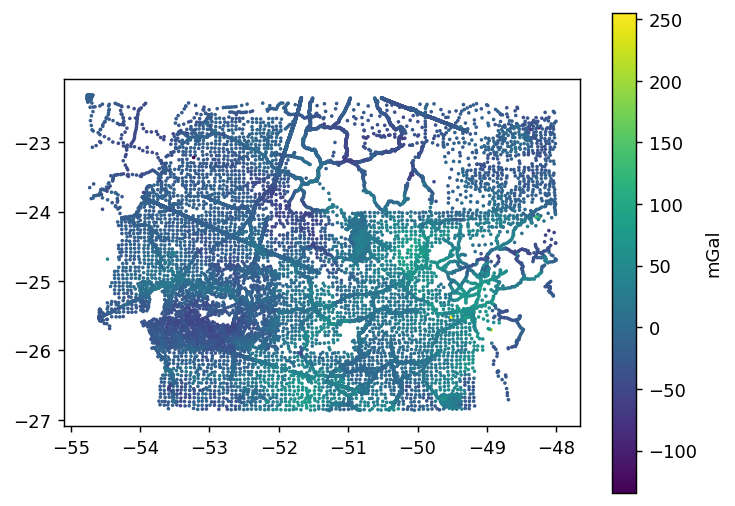

In [ ]:
#Plotando gravit disturbance
tmp = plt.scatter(dados.LONG, dados.LAT, c=dados.gravit_disturbance, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")

In [ ]:
#Fazendo upload da topografia

# Substitua '/content/drive/MyDrive/seu_arquivo.csv' pelo caminho real do seu arquivo no Google Drive
caminho_do_arquivo = '/content/drive/MyDrive/mesclar/topo.csv'

# Carregue o arquivo CSV como um DataFrame do Pandas
df = pd.read_csv(caminho_do_arquivo)

df

,cota,y,x
0,420,7527318,112459
1,417,7527318,112959
2,426,7527318,113459
3,416,7527318,113959
4,400,7527318,114459
...,...,...,...
1415578,0,7028402,818544
1415579,0,7028402,819044
1415580,0,7028402,819544
1415581,0,7028402,820044


In [ ]:
# Crie o xarray.Dataset com as dimensões explicitamente definidas
topography = xr.Dataset.from_dataframe(df.set_index(['y', 'x']))

# Defina as unidades e nomes das coordenadas
topography['x'].attrs['units'] = 'metros'
topography['x'].attrs['standard_name'] = 'x'
topography['y'].attrs['units'] = 'metros'
topography['y'].attrs['standard_name'] = 'y'
topography['cota'].attrs['units'] = 'metros'

# Converta as coordenadas bidimensionais em unidimensionais
easting = np.linspace(np.min(topography['x'].values), np.max(topography['x'].values), topography['x'].size)
northing = np.linspace(np.min(topography['y'].values), np.max(topography['y'].values), topography['y'].size)

# Crie os prismas usando as coordenadas unidimensionais
prisms_centers = (easting, northing)
surface = np.abs(topography['cota'].values)
density = 2670 * np.ones_like(surface)

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface=surface,
    reference=0,
    properties={"density": density}
)

topo_prisms

<xarray.Dataset>
Dimensions:   (northing: 999, easting: 1417)
Coordinates:
  * easting   (easting) float64 1.125e+05 1.13e+05 ... 8.2e+05 8.205e+05
  * northing  (northing) float64 7.028e+06 7.029e+06 ... 7.527e+06 7.527e+06
    top       (northing, easting) int64 241 229 214 229 193 ... 790 769 795 768
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 2670 2670
Attributes:
    coords_units:      meters
    properties_units:  SI

Dados salvos em: /content/drive/MyDrive/dados_geofisicos/dados_saida.csv


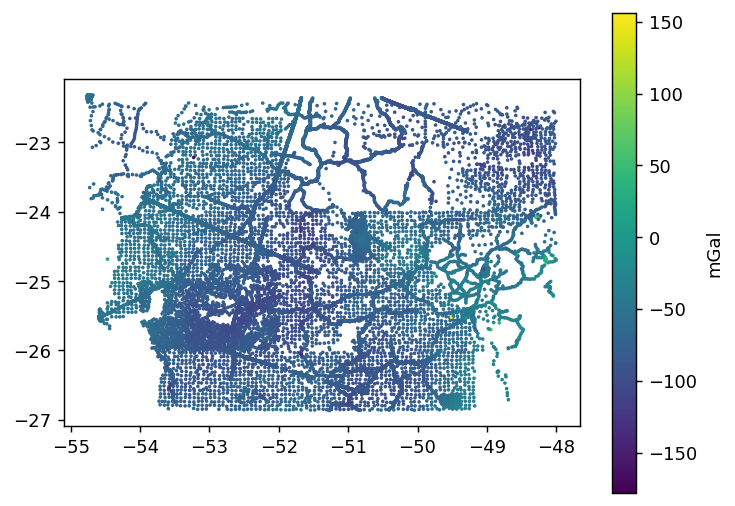

In [ ]:
# Define as coordenadas onde vamos calcular o efeito da gravidade dos prismas, aqui é preciso usar as coordenadas planas
coordinates = (dados.x, dados.y, dados.z)

# Use o acessor "prism_layer" para calcular o campo gravitacional da camada
result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

# Calcule a anomalia gravitacional de Bouguer
bouguer_disturbance = dados.gravit_disturbance - result

# Adicione a anomali de Bouguer ao conjunto de dados como uma coluna
dados = dados.assign(bouguer_disturbance=bouguer_disturbance)

# Salve os dados em um arquivo CSV, especifique o caminho no google drive
file_path = '/content/drive/MyDrive/dados_geofisicos/dados_saida.csv'  # Especifique o caminho desejado para salvar o arquivo
dados.to_csv(file_path, index=False)
print(f'Dados salvos em: {file_path}')

#Plotando a anomalia de Bouguer
tmp = plt.scatter(dados.LONG, dados.LAT, c=dados.bouguer_disturbance, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")